In [0]:
# Import required packages and cifar-10 dataset from keras.

import pandas as pd
import numpy as np

from keras.datasets import cifar10
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, Callback, EarlyStopping
from keras.optimizers import SGD,Adam
from keras.utils import np_utils
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import keras.backend as K

Using TensorFlow backend.


In [0]:
# Load the cifar-10 dataset and store the training and testing images in X_train, Y_train and X_text, Y_test

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print("Train Set Size = {} images".format(X_train.shape[0]))
print("Test Set Size = {} images".format(X_test.shape[0]))

Train Set Size = 50000 images
Test Set Size = 10000 images


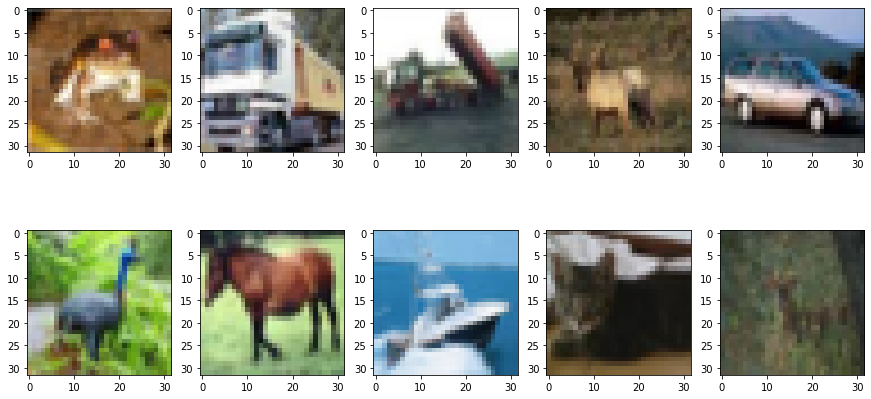

Labels : [[6]
 [9]
 [9]
 [4]
 [1]]
Labels : [[2]
 [7]
 [8]
 [3]
 [4]]


In [0]:
# Display few images from training sample

fig1 = plt.figure(figsize = (15,15))

for i in range(5):
    ax1 = fig1.add_subplot(1,5,i+1) 
    ax1.imshow(X_train[i], interpolation='none', cmap=plt.cm.gray)
    ax2 = fig1.add_subplot(2,5,i+6) 
    ax2.imshow(X_train[i+6], interpolation='none', cmap=plt.cm.gray)
plt.show()

print("Labels : {}".format(y_train[0:5]))
print("Labels : {}".format(y_train[6:11]))

**The label data is just a list of 10,000 numbers ranging from 0 to 9, which corresponds to each of the 10 classes in CIFAR-10.**

airplane : 0, automobile : 1, bird : 2, cat : 3, deer : 4, dog : 5, frog : 6, horse : 7, ship : 8, truck : 9

In [0]:
# Data Preprocessing

# convert to categorical
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10) 

# float and normalization
X_train = X_train.astype('float32'); X_test = X_test.astype('float32');
X_train /= 255; X_test /= 255;


In [0]:
# Build the VGG-16 model

sgd = SGD(lr=1e-3, decay=5e-4, momentum=0.9, nesterov=True)

adam = Adam(lr=1e-3)

def vgg16():
    model = Sequential()
 
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(32,32,3)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
 
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

# Store the defined model in a variable
model = vgg16()

In [0]:
# Summary of built VGG-16 model
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 128)      

In [0]:
# Configure training parameters 

nb_epoch = 50
batch_size = 32

## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))

early_stopping = EarlyStopping(monitor='val_loss', patience=100, verbose=1, mode='auto')

def run_vgg16():
    
    history = LossHistory()
    model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch,
              validation_split=0.1, verbose=1, shuffle=True, callbacks=[history, early_stopping])
    

    predictions = model.predict(X_test, verbose=0)
    return predictions, history

def test_accuracy():
    tp = []
    err = []
    t = 0
    for i in range(predictions.shape[0]):
        if (np.argmax(predictions[i]) == y_test[i]):
            t = t+1
            tp.append(i)
        else:
            err.append(i)
    return t, float(t)*100/predictions.shape[0], err, tp

In [0]:
# Traing the built VGG-16 model
%%time
predictions, history = run_vgg16()

Train on 45000 samples, validate on 5000 samples
Epoch 1/50
45000/45000 [==============================] - 94s 2ms/step - loss: 2.0826 - accuracy: 0.1693 - val_loss: 2.0757 - val_accuracy: 0.1886
Epoch 2/50
45000/45000 [==============================] - 90s 2ms/step - loss: 1.9781 - accuracy: 0.1871 - val_loss: 2.0707 - val_accuracy: 0.1788
Epoch 3/50
45000/45000 [==============================] - 90s 2ms/step - loss: 1.9241 - accuracy: 0.2112 - val_loss: 1.9613 - val_accuracy: 0.2356
Epoch 4/50
45000/45000 [==============================] - 92s 2ms/step - loss: 1.8503 - accuracy: 0.2530 - val_loss: 1.9522 - val_accuracy: 0.2958
Epoch 5/50
45000/45000 [==============================] - 92s 2ms/step - loss: 1.6493 - accuracy: 0.3425 - val_loss: 1.3907 - val_accuracy: 0.4484
Epoch 6/50
45000/45000 [==============================] - 91s 2ms/step - loss: 1.4667 - accuracy: 0.4374 - val_loss: 1.4144 - val_accuracy: 0.4430
Epoch 7/50
45000/45000 [==============================] - 91s 2ms/ste

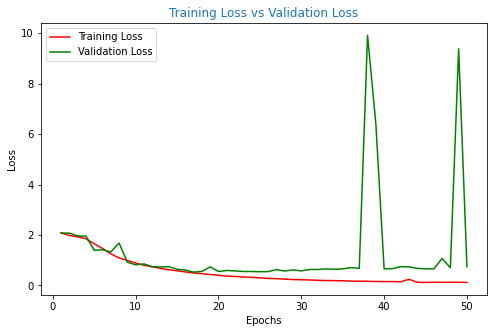

In [0]:
# Check the Training loss and Validation loss over epoch size
fig, ax = plt.subplots(figsize=(8, 5))
ax.set_title('Training Loss vs Validation Loss', color='C0')
ax.set(xlabel='Epochs', ylabel='Loss')
ax.plot(range(1,nb_epoch+1),history.losses,  label='Training Loss',color='red')
ax.plot(range(1,nb_epoch+1),history.val_losses, label='Validation Loss', color='green')
ax.legend()

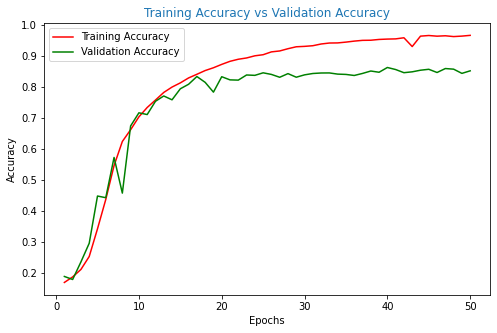

In [0]:
# Check the Training Accuracy and Validation Accuracy over epoch size
fig, ax = plt.subplots(figsize=(8, 5))
ax.set_title('Training Accuracy vs Validation Accuracy', color='C0')
ax.set(xlabel='Epochs', ylabel='Accuracy')
ax.plot(range(1,nb_epoch+1),history.acc,  label='Training Accuracy',color='red')
ax.plot(range(1,nb_epoch+1),history.val_acc, label='Validation Accuracy', color='green')
ax.legend()

In [0]:
# Evaluate the Test Accuracy

p = test_accuracy()
print("Test accuracy: {} %".format(p[1]))

Test accuracy: 85.17 %


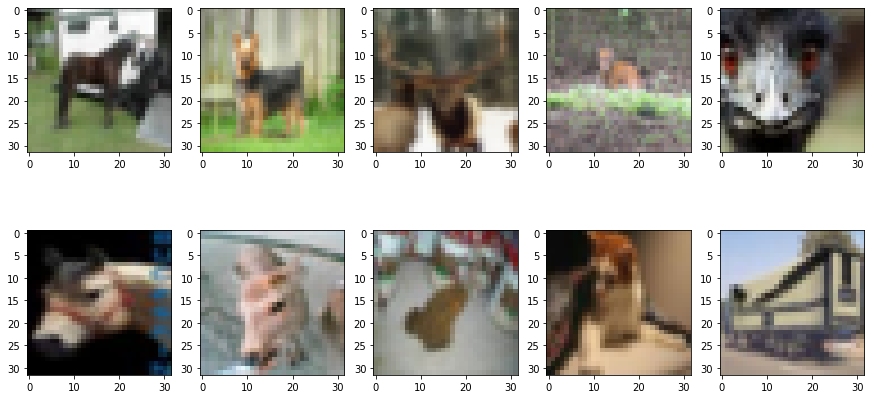

True:          [[7]
 [5]
 [4]
 [4]
 [2]]
classified as: [9 4 3 2 8]
True:          [[7]
 [4]
 [6]
 [3]
 [9]]
classified as: [3 7 3 5 0]


In [0]:
# Visualize few incorrectly classified test samples

fig1 = plt.figure(figsize = (15,15))

for i in range(5):
    ax1 = fig1.add_subplot(1,5,i+1) 
    ax1.imshow(X_test[p[2][i]], interpolation='none', cmap=plt.cm.gray)
    ax2 = fig1.add_subplot(2,5,i+6) 
    ax2.imshow(X_test[p[2][i+6]], interpolation='none', cmap=plt.cm.gray)
plt.show()

print("True:          {}".format(y_test[p[2][0:5]]))
print("classified as: {}".format(np.argmax(predictions[p[2][0:5]], axis=1)))

print("True:          {}".format(y_test[p[2][6:11]]))
print("classified as: {}".format(np.argmax(predictions[p[2][6:11]], axis=1)))

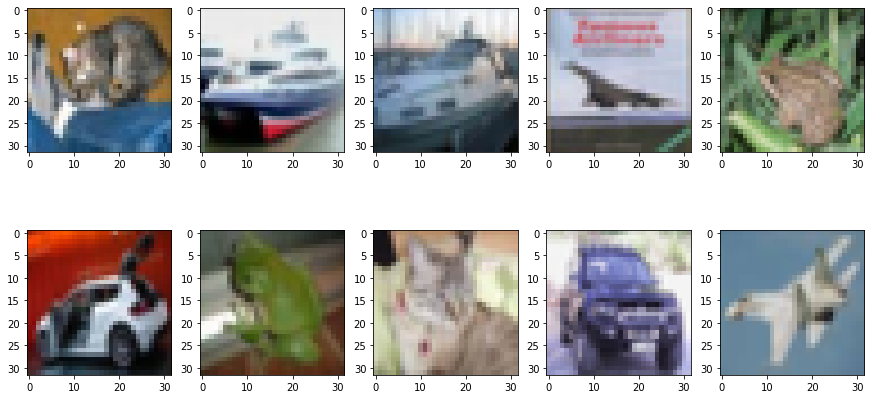

True:          [[3]
 [8]
 [8]
 [0]
 [6]]
classified as: [3 8 8 0 6]
True:          [[1]
 [6]
 [3]
 [1]
 [0]]
classified as: [1 6 3 1 0]


In [0]:
# Visualize few correctly classified test samples

fig1 = plt.figure(figsize = (15,15))

for i in range(5):
    ax1 = fig1.add_subplot(1,5,i+1) 
    ax1.imshow(X_test[p[3][i]], interpolation='none', cmap=plt.cm.gray)
    ax2 = fig1.add_subplot(2,5,i+6) 
    ax2.imshow(X_test[p[3][i+6]], interpolation='none', cmap=plt.cm.gray)
plt.show()

print("True:          {}".format(y_test[p[3][0:5]]))
print("classified as: {}".format(np.argmax(predictions[p[3][0:5]], axis=1)))

print("True:          {}".format(y_test[p[3][6:11]]))
print("classified as: {}".format(np.argmax(predictions[p[3][6:11]], axis=1)))